In [58]:
from mlforecast import MLForecast
from mlforecast.auto import AutoMLForecast, AutoLightGBM, AutoXGBoost, AutoRidge
from statsforecast.utils import AirPassengersDF
from utilsforecast.data import generate_series

df = AirPassengersDF
df

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0
...,...,...,...
139,1.0,1960-08-31,606.0
140,1.0,1960-09-30,508.0
141,1.0,1960-10-31,461.0
142,1.0,1960-11-30,390.0


In [82]:
models={
        'lgb': AutoLightGBM(),
        'xgb': AutoXGBoost(),
        'ridge': AutoRidge()
    }

auto_mlf = AutoMLForecast(
    freq='ME',  # frequency of your time series (e.g., 'D' for daily, 'W' for weekly)
    season_length=12,  # length of seasonality in your data
    models=models,
    num_threads=4  # number of threads to use for parallel processing
)

In [93]:
auto_mlf.fit(n_windows=3, df=df, h = 12, num_samples=10)


[I 2024-09-01 21:29:24,224] A new study created in memory with name: no-name-81048c44-e054-413e-b6a8-9f27e2327c39
[I 2024-09-01 21:29:25,427] Trial 0 finished with value: 0.08544112431217703 and parameters: {'n_estimators': 169, 'lambda_l1': 0.027334069690310565, 'lambda_l2': 0.0026599310838681858, 'num_leaves': 112, 'feature_fraction': 0.7118273996694524, 'bagging_fraction': 0.8229470565333281, 'objective': 'l2', 'target_transforms_idx': 0, 'lags_idx': 2, 'lag_transforms_idx': 2, 'use_date_features': 1}. Best is trial 0 with value: 0.08544112431217703.
[I 2024-09-01 21:29:25,853] Trial 1 finished with value: 0.07004212241784373 and parameters: {'n_estimators': 120, 'lambda_l1': 0.10586748269028218, 'lambda_l2': 1.1600316346542318e-07, 'num_leaves': 237, 'feature_fraction': 0.5716766437045232, 'bagging_fraction': 0.972334458524792, 'objective': 'l1', 'target_transforms_idx': 1, 'lags_idx': 1, 'lag_transforms_idx': 2, 'use_date_features': 0}. Best is trial 1 with value: 0.07004212241784

AutoMLForecast(models={'lgb': AutoModel(model=LGBMRegressor), 'xgb': AutoModel(model=XGBRegressor), 'ridge': AutoModel(model=Ridge)})

In [61]:
auto_mlf.results_['lgb'].best_trial.user_attrs['config']

{'model_params': {'bagging_freq': 1,
  'learning_rate': 0.05,
  'verbosity': -1,
  'n_estimators': 84,
  'lambda_l1': 1.1683132741241065,
  'lambda_l2': 1.9110071392827473e-05,
  'num_leaves': 2,
  'feature_fraction': 0.6532568262431082,
  'bagging_fraction': 0.8834009802514554,
  'objective': 'l1'},
 'mlf_init_params': {'lags': [12],
  'target_transforms': [<mlforecast.target_transforms.Differences at 0x1d3454e26c0>,
  'lag_transforms': None,
  'date_features': None,
  'num_threads': 4},
 'mlf_fit_params': {}}

In [62]:
from lightgbm import LGBMRegressor

config = auto_mlf.results_['lgb'].best_trial.user_attrs['config']

In [63]:
config['mlf_init_params']

{'lags': [12],
 'target_transforms': [<mlforecast.target_transforms.Differences at 0x1d3459a4920>,
 'lag_transforms': None,
 'date_features': None,
 'num_threads': 4}

In [64]:
config['model_params']

{'bagging_freq': 1,
 'learning_rate': 0.05,
 'verbosity': -1,
 'n_estimators': 84,
 'lambda_l1': 1.1683132741241065,
 'lambda_l2': 1.9110071392827473e-05,
 'num_leaves': 2,
 'feature_fraction': 0.6532568262431082,
 'bagging_fraction': 0.8834009802514554,
 'objective': 'l1'}

In [65]:
# config = auto_mlf.results_['lgbm'].best_trial.user_attrs['config']
fcst = MLForecast(models=[LGBMRegressor(**config['model_params'])], **config['mlf_init_params'], freq='ME')
fcst.fit(df)
                                                          
                                                          

MLForecast(models=[LGBMRegressor], freq=ME, lag_features=['lag12'], date_features=[], num_threads=4)

In [66]:
fcst.predict(h=12)

,unique_id,ds,LGBMRegressor
0,1.0,1961-01-31,448.326611
1,1.0,1961-02-28,426.653223
2,1.0,1961-03-31,458.979834
3,1.0,1961-04-30,496.043163
4,1.0,1961-05-31,511.369774
5,1.0,1961-06-30,569.433103
6,1.0,1961-07-31,651.496432
7,1.0,1961-08-31,639.823043
8,1.0,1961-09-30,540.735604
9,1.0,1961-10-31,492.427386


In [98]:
import pandas as pd

def get_forecast(auto_mlf, models, df, h):
    forecast_df = None

    for model_name, model in models.items():
        try:
            # Fit the model and make predictions
            fitted_model = auto_mlf.models_[model_name].fit(df)
            forecast = fitted_model.predict(h)
            
            # Rename the forecast column to include the model name
            forecast = forecast.rename(columns={model_name: f'{model_name}_forecast'})
            
            if forecast_df is None:
                forecast_df = forecast
            else:
                # Merge on 'unique_id' and 'ds'
                forecast_df = pd.merge(forecast_df, forecast, on=['unique_id', 'ds'], how='outer')
        
        except Exception as e:
            print(f"Error forecasting with {model_name}: {str(e)}")
    
    return forecast_df

In [ ]:
fcst = auto_mlf.models_['lgb'].fit(df)
forecast = fcst.predict(h=12)
forecast

In [97]:
print(forecast)

    unique_id         ds         lgb
0         1.0 1961-01-31  438.596312
1         1.0 1961-02-28  422.513605
2         1.0 1961-03-31  451.743715
3         1.0 1961-04-30  483.286231
4         1.0 1961-05-31  490.758602
5         1.0 1961-06-30  534.474381
6         1.0 1961-07-31  580.934037
7         1.0 1961-08-31  566.472681
8         1.0 1961-09-30  524.716803
9         1.0 1961-10-31  487.718825
10        1.0 1961-11-30  453.854722
11        1.0 1961-12-31  489.380481


In [94]:
fcst = auto_mlf.models_['lgb'].fit(df)
forecast = fcst.predict(h=12)

cross_val = fcst.cross_validation(df, h = 12, n_windows=3, fitted = True)
cv_fitted =  fcst.cross_validation_fitted_values()
cv_fitted


,unique_id,ds,fold,y,lgb
0,1.0,1950-02-28,0,126.0,122.528130
1,1.0,1950-03-31,0,141.0,136.796763
2,1.0,1950-04-30,0,135.0,138.369154
3,1.0,1950-05-31,0,125.0,130.842551
4,1.0,1950-06-30,0,149.0,134.595199
...,...,...,...,...,...
316,1.0,1959-08-31,2,559.0,555.466140
317,1.0,1959-09-30,2,463.0,518.963353
318,1.0,1959-10-31,2,407.0,436.163961
319,1.0,1959-11-30,2,362.0,378.959579


In [99]:
forecast = get_forecast(auto_mlf, models, df, h=12)
forecast

c:\Users\wesst\toolkit\tool-kit\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:33:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "bagging_freq", "min_data_in_leaf" } are not used.

  warnings.warn(smsg, UserWarning)


,unique_id,ds,lgb_forecast,xgb_forecast,ridge_forecast
0,1.0,1961-01-31,438.596312,446.484523,446.273826
1,1.0,1961-02-28,422.513605,426.837736,415.556416
2,1.0,1961-03-31,451.743715,474.311007,441.821661
3,1.0,1961-04-30,483.286231,509.850208,482.410359
4,1.0,1961-05-31,490.758602,515.467598,505.795847
5,1.0,1961-06-30,534.474381,583.448121,570.505492
6,1.0,1961-07-31,580.934037,673.041443,660.476265
7,1.0,1961-08-31,566.472681,676.239324,635.569309
8,1.0,1961-09-30,524.716803,563.997106,544.397500
9,1.0,1961-10-31,487.718825,514.740266,487.443255


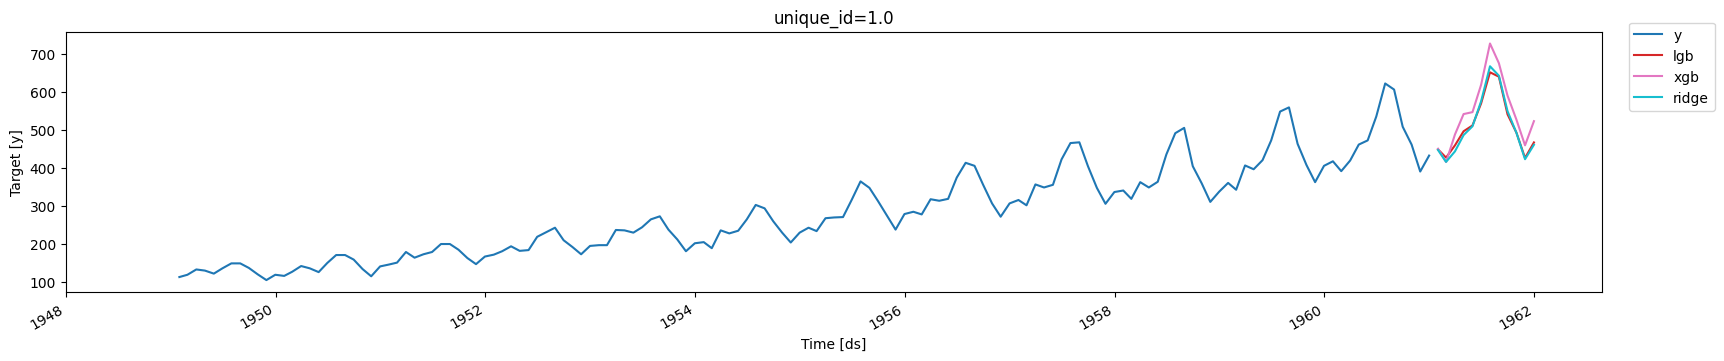

In [67]:
from utilsforecast.plotting import plot_series
plot_series(df, auto_mlf.predict(h=12))

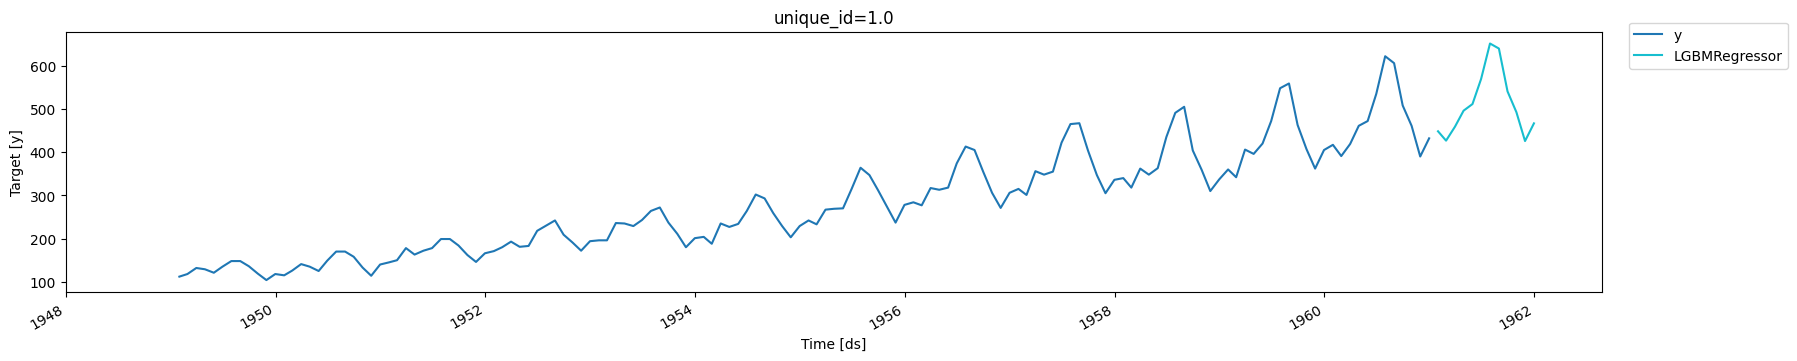

In [68]:
plot_series(df, fcst.predict(h=12))

In [69]:
model = auto_mlf.models_['lgb']

In [70]:
model.models_, model

({'lgb': LGBMRegressor(bagging_fraction=0.8834009802514554, bagging_freq=1,
                feature_fraction=0.6532568262431082, lambda_l1=1.1683132741241065,
                lambda_l2=1.9110071392827473e-05, learning_rate=0.05,
                n_estimators=84, num_leaves=2, objective='l1', verbosity=-1)},
 MLForecast(models=[lgb], freq=ME, lag_features=['lag12'], date_features=[], num_threads=4))

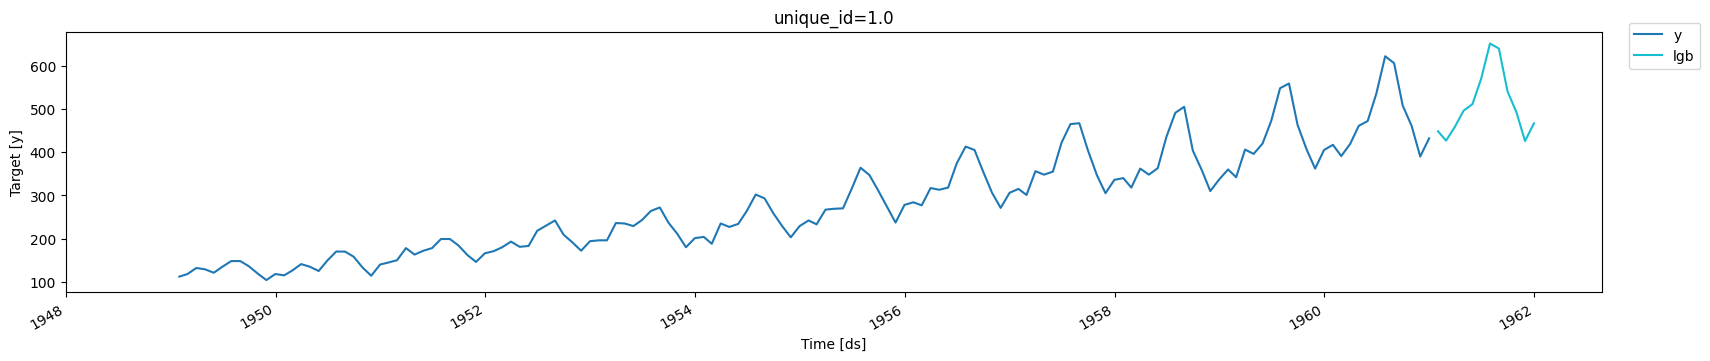

In [72]:
plot_series(df,model.fit(df).predict(h=12))

In [16]:
cross = model.cross_validation(df=series,n_windows=3, h = 12)
cross


,unique_id,ds,cutoff,y,lgb
0,0,2015-07-31,2015-06-30,0.104922,0.244193
1,0,2015-08-31,2015-06-30,0.093097,0.279021
2,0,2015-09-30,2015-06-30,0.472186,0.241066
3,0,2015-10-31,2015-06-30,0.369775,0.312682
4,0,2015-11-30,2015-06-30,0.245229,0.260888
...,...,...,...,...,...
355,9,2021-05-31,2020-09-30,0.472237,0.296081
356,9,2021-06-30,2020-09-30,0.364189,0.331049
357,9,2021-07-31,2020-09-30,0.258369,0.298946
358,9,2021-08-31,2020-09-30,0.388596,0.305834


In [25]:
model.fit(df=series).predict(h=12)

,unique_id,ds,lgb
0,0,2018-07-31,0.234606
1,0,2018-08-31,0.269555
2,0,2018-09-30,0.305177
3,0,2018-10-31,0.314042
4,0,2018-11-30,0.243941
...,...,...,...
115,9,2022-05-31,0.227641
116,9,2022-06-30,0.225712
117,9,2022-07-31,0.242247
118,9,2022-08-31,0.229892


In [26]:
auto_mlf.predict(h=12)

,unique_id,ds,lgb,xgb,ridge
0,0,2018-07-31,0.234606,0.273389,0.251708
1,0,2018-08-31,0.269555,0.244587,0.249661
2,0,2018-09-30,0.305177,0.208334,0.249831
3,0,2018-10-31,0.314042,0.311377,0.250011
4,0,2018-11-30,0.243941,0.227403,0.250689
...,...,...,...,...,...
115,9,2022-05-31,0.227641,0.274555,0.259856
116,9,2022-06-30,0.225712,0.271422,0.259719
117,9,2022-07-31,0.242247,0.297759,0.258992
118,9,2022-08-31,0.229892,0.266341,0.259834


In [54]:
from mlforecast.auto import AutoMLForecast, AutoLightGBM, AutoXGBoost, AutoRidge

# Assuming df is your dataframe with all series
series_list = df['unique_id'].unique()

models = {}

for series_id in series_list:
    series_data = df[df['unique_id'] == series_id]
    
    auto_mlf = AutoMLForecast(
        freq='ME',  # adjust as needed
        season_length=12,  # adjust as needed
        models={
            'lgb': AutoLightGBM(),
            'xgb': AutoXGBoost(),
            'ridge': AutoRidge()
        },
        num_threads=4
    )
    
    auto_mlf.fit(
        df=series_data,
        n_windows=3,
        h=12,
        num_samples=50
    )
    
    models[series_id] = auto_mlf

[I 2024-08-30 00:30:05,988] A new study created in memory with name: no-name-03eeb7d4-ee3f-4451-b264-7c91098e25a1
[I 2024-08-30 00:30:06,635] Trial 0 finished with value: 0.08544112431217703 and parameters: {'n_estimators': 169, 'lambda_l1': 0.027334069690310565, 'lambda_l2': 0.0026599310838681858, 'num_leaves': 112, 'feature_fraction': 0.7118273996694524, 'bagging_fraction': 0.8229470565333281, 'objective': 'l2', 'target_transforms_idx': 0, 'lags_idx': 2, 'lag_transforms_idx': 2, 'use_date_features': 1}. Best is trial 0 with value: 0.08544112431217703.
[I 2024-08-30 00:30:06,878] Trial 1 finished with value: 0.07004212241784373 and parameters: {'n_estimators': 120, 'lambda_l1': 0.10586748269028218, 'lambda_l2': 1.1600316346542318e-07, 'num_leaves': 237, 'feature_fraction': 0.5716766437045232, 'bagging_fraction': 0.972334458524792, 'objective': 'l1', 'target_transforms_idx': 1, 'lags_idx': 1, 'lag_transforms_idx': 2, 'use_date_features': 0}. Best is trial 1 with value: 0.07004212241784

In [56]:
predictions = {}

for series_id, model in models.items():
    # Predict for each series
    pred = model.predict(h=12)  # Assuming you want to predict 12 steps ahead
    predictions[series_id] = pred

In [57]:
predictions

{np.float64(1.0):     unique_id         ds         lgb         xgb       ridge
 0         1.0 1961-01-31  448.326611  450.040658  446.614940
 1         1.0 1961-02-28  426.653223  415.028108  415.385526
 2         1.0 1961-03-31  458.979834  487.666614  443.082142
 3         1.0 1961-04-30  496.043163  541.386730  485.986858
 4         1.0 1961-05-31  511.369774  546.510619  509.137837
 5         1.0 1961-06-30  569.433103  618.456186  574.949837
 6         1.0 1961-07-31  651.496432  727.328973  667.344918
 7         1.0 1961-08-31  639.823043  675.347184  642.376859
 8         1.0 1961-09-30  540.735604  590.056908  549.115259
 9         1.0 1961-10-31  492.427386  526.788236  492.094650
 10        1.0 1961-11-30  425.753998  459.047126  422.441501
 11        1.0 1961-12-31  466.666559  522.729535  460.458724}

In [58]:
auto_mlf.results_['lgb'].best_params
auto_mlf.results_['lgb'].best_value
auto_mlf.results_['lgb'].best_params


{'n_estimators': 84,
 'lambda_l1': 1.1683132741241065,
 'lambda_l2': 1.9110071392827473e-05,
 'num_leaves': 2,
 'feature_fraction': 0.6532568262431082,
 'bagging_fraction': 0.8834009802514554,
 'objective': 'l1',
 'target_transforms_idx': 5,
 'lags_idx': 1,
 'lag_transforms_idx': 0,
 'use_date_features': 0}

In [22]:
auto_mlf.results_['lgb']

In [27]:
auto_mlf.results_['lgb'].best_trial



FrozenTrial(number=0, state=1, values=[0.30080510597465543], datetime_start=datetime.datetime(2024, 8, 30, 0, 13, 12, 113741), datetime_complete=datetime.datetime(2024, 8, 30, 0, 13, 12, 734235), params={'n_estimators': 169, 'lambda_l1': 0.027334069690310565, 'lambda_l2': 0.0026599310838681858, 'num_leaves': 112, 'feature_fraction': 0.7118273996694524, 'bagging_fraction': 0.8229470565333281, 'objective': 'l2', 'target_transforms_idx': 0, 'lags_idx': 2, 'lag_transforms_idx': 2, 'use_date_features': 0}, user_attrs={'config': {'model_params': {'bagging_freq': 1, 'learning_rate': 0.05, 'verbosity': -1, 'n_estimators': 169, 'lambda_l1': 0.027334069690310565, 'lambda_l2': 0.0026599310838681858, 'num_leaves': 112, 'feature_fraction': 0.7118273996694524, 'bagging_fraction': 0.8229470565333281, 'objective': 'l2'}, 'mlf_init_params': {'lags': range(1, 13), 'target_transforms': None, 'lag_transforms': {1: [ExponentiallyWeightedMean(alpha=0.9)], 12: [RollingMean(min_samples=1, window_size=12)]}, '

In [44]:
def summarize_trials(study):
    summary = []
    for trial in study.trials:
        trial_summary = {
            'Trial Number': trial.number,
            'State': trial.state.name,
            'Value': trial.values,
            'Start Time': trial.datetime_start.strftime('%Y-%m-%d %H:%M:%S'),
            'End Time': trial.datetime_complete.strftime('%Y-%m-%d %H:%M:%S'),
            'Params': trial.params,
            'Intermediate Values': trial.intermediate_values
        }
        summary.append(trial_summary)
    return summary

def print_trial_summary(summary):
    for trial in summary:
        print(f"Trial {trial['Trial Number']}:")
        print(f"  State: {trial['State']}")
        print(f"  Value: {trial['Value']}")
        print(f"  Start Time: {trial['Start Time']}")
        print(f"  End Time: {trial['End Time']}")
        print(f"  Parameters:")
        for param, value in trial['Params'].items():
            print(f"    {param}: {value}")
        print(f"  Intermediate Values:")
        for step, value in trial['Intermediate Values'].items():
            print(f"    Step {step}: {value}")
        print("-" * 40)

# Usage
study = auto_mlf.results_['lgb']
trial_summary = summarize_trials(study)
print_trial_summary(trial_summary)


Trial 0:
  State: COMPLETE
  Value: [0.320531071143874]
  Start Time: 2024-08-30 00:23:50
  End Time: 2024-08-30 00:23:50
  Parameters:
    n_estimators: 169
    lambda_l1: 0.027334069690310565
    lambda_l2: 0.0026599310838681858
    num_leaves: 112
    feature_fraction: 0.7118273996694524
    bagging_fraction: 0.8229470565333281
    objective: l2
    target_transforms_idx: 0
    lags_idx: 0
    lag_transforms_idx: 1
    use_date_features: 1
  Intermediate Values:
    Step 0: 0.3422901117934245
    Step 1: 0.3092476076319799
    Step 2: 0.3100554940062177
----------------------------------------
Trial 1:
  State: COMPLETE
  Value: [0.3199024696984551]
  Start Time: 2024-08-30 00:23:50
  End Time: 2024-08-30 00:23:52
  Parameters:
    n_estimators: 920
    lambda_l1: 0.15574964948467418
    lambda_l2: 0.00014233583723829364
    num_leaves: 722
    feature_fraction: 0.5591372129344666
    bagging_fraction: 0.819960510663762
    objective: l2
    target_transforms_idx: 3
    lags_idx: 2


In [45]:
auto_mlf.results_['lgb'].best_value



0.3064126004255726

In [46]:
def summarize_trials(study):
    summary = []
    for trial in study.trials:
        trial_summary = {
            'Trial Number': trial.number,
            'State': trial.state.name,
            'Objective Value (Loss)': trial.value,  # Include the loss function value
            'Values': trial.values,  # For multi-objective optimization, this will be a list
            'Start Time': trial.datetime_start.strftime('%Y-%m-%d %H:%M:%S'),
            'End Time': trial.datetime_complete.strftime('%Y-%m-%d %H:%M:%S'),
            'Params': trial.params,
            'Intermediate Values': trial.intermediate_values
        }
        summary.append(trial_summary)
    return summary

def print_trial_summary(summary):
    for trial in summary:
        print(f"Trial {trial['Trial Number']}:")
        print(f"  State: {trial['State']}")
        print(f"  Objective Value (Loss): {trial['Objective Value (Loss)']}")
        if trial['Values'] is not None:
            print(f"  Values: {trial['Values']}")
        print(f"  Start Time: {trial['Start Time']}")
        print(f"  End Time: {trial['End Time']}")
        print(f"  Parameters:")
        for param, value in trial['Params'].items():
            print(f"    {param}: {value}")
        if trial['Intermediate Values']:
            print(f"  Intermediate Values:")
            for step, value in trial['Intermediate Values'].items():
                print(f"    Step {step}: {value}")
        print("-" * 40)

# Usage
study = auto_mlf.results_['lgb']
trial_summary = summarize_trials(study)
print_trial_summary(trial_summary)


Trial 0:
  State: COMPLETE
  Objective Value (Loss): 0.320531071143874
  Values: [0.320531071143874]
  Start Time: 2024-08-30 00:23:50
  End Time: 2024-08-30 00:23:50
  Parameters:
    n_estimators: 169
    lambda_l1: 0.027334069690310565
    lambda_l2: 0.0026599310838681858
    num_leaves: 112
    feature_fraction: 0.7118273996694524
    bagging_fraction: 0.8229470565333281
    objective: l2
    target_transforms_idx: 0
    lags_idx: 0
    lag_transforms_idx: 1
    use_date_features: 1
  Intermediate Values:
    Step 0: 0.3422901117934245
    Step 1: 0.3092476076319799
    Step 2: 0.3100554940062177
----------------------------------------
Trial 1:
  State: COMPLETE
  Objective Value (Loss): 0.3199024696984551
  Values: [0.3199024696984551]
  Start Time: 2024-08-30 00:23:50
  End Time: 2024-08-30 00:23:52
  Parameters:
    n_estimators: 920
    lambda_l1: 0.15574964948467418
    lambda_l2: 0.00014233583723829364
    num_leaves: 722
    feature_fraction: 0.5591372129344666
    bagging_

In [51]:
auto_mlf.results_['lgb'].best_trial

FrozenTrial(number=35, state=1, values=[0.3064126004255726], datetime_start=datetime.datetime(2024, 8, 30, 0, 24, 3, 614161), datetime_complete=datetime.datetime(2024, 8, 30, 0, 24, 3, 889199), params={'n_estimators': 77, 'lambda_l1': 0.2623123362300478, 'lambda_l2': 0.0030612992049287007, 'num_leaves': 20, 'feature_fraction': 0.8992166413846229, 'bagging_fraction': 0.5006295613082734, 'objective': 'l1', 'target_transforms_idx': 0, 'lags_idx': 1, 'lag_transforms_idx': 2, 'use_date_features': 0}, user_attrs={'config': {'model_params': {'bagging_freq': 1, 'learning_rate': 0.05, 'verbosity': -1, 'n_estimators': 77, 'lambda_l1': 0.2623123362300478, 'lambda_l2': 0.0030612992049287007, 'num_leaves': 20, 'feature_fraction': 0.8992166413846229, 'bagging_fraction': 0.5006295613082734, 'objective': 'l1'}, 'mlf_init_params': {'lags': [12], 'target_transforms': None, 'lag_transforms': {1: [ExponentiallyWeightedMean(alpha=0.9)], 12: [RollingMean(min_samples=1, window_size=12)]}, 'date_features': No

In [52]:
from utilsforecast.plotting import plot_series

In [61]:
import pandas as pd
predictions = pd.DataFrame(predictions)

ValueError: If using all scalar values, you must pass an index

In [59]:
plot_series(series, predictions)

AttributeError: 'dict' object has no attribute 'columns'

In [10]:
from mlforecast.auto import AutoModel, AutoMLForecast
import optuna

In [11]:
from sklearn.linear_model import (
    LinearRegression, 
    TheilSenRegressor,
    RANSACRegressor,
    HuberRegressor,
    QuantileRegressor,
    Lasso, 
    LassoCV,
    Ridge, 
    RidgeCV,
    ElasticNet, 
    ElasticNetCV,

)

In [12]:
def lasso_space(trial):
    return {
        'alpha': trial.suggest_float('alpha', 1e-5, 1, log = True),
        'max_iter': trial.suggest_int('max_iter', 100, 1000)
    }

def ridge_space(trial):
    return {
        'alpha': trial.suggest_float('alpha', 1e-5, 100, log = True),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'max_iter': trial.suggest_int('max_iter', 100, 10000),
        'tol': trial.suggest_float('tol', 1e-6, 1e-2,log = True),
        # 'solver': trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']),
        'positive': trial.suggest_categorical('positive', [True, False])
    }

In [13]:
from mlforecast.auto import (
    AutoLightGBM,
    AutoXGBoost,
    AutoCatboost,
    AutoRidge,
    AutoLasso,
    AutoElasticNet,
    AutoLinearRegression,
    AutoRandomForest
)

# Scikit-learn models
from sklearn.linear_model import (
    LinearRegression, 
    TheilSenRegressor,
    RANSACRegressor,
    HuberRegressor,
    QuantileRegressor,
    Lasso, 
    LassoCV,
    Ridge, 
    ElasticNet, 
    ElasticNetCV,

)
from sklearn.neighbors import (
    KNeighborsRegressor,
    )

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor,
    AdaBoostRegressor,
    BaggingRegressor)
from sklearn.svm import SVR, LinearSVR

In [14]:
import optuna
from mlforecast.auto import AutoModel, AutoLightGBM, AutoXGBoost, AutoRidge, AutoLasso, AutoElasticNet, AutoLinearRegression, AutoRandomForest

def lasso_space(trial):
    return {
        'alpha': trial.suggest_loguniform('alpha', 1e-5, 10),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'max_iter': trial.suggest_int('max_iter', 100, 3000),
        'tol': trial.suggest_loguniform('tol', 1e-5, 1e-2),
        'selection': trial.suggest_categorical('selection', ['cyclic', 'random'])
    }

def lassocv_space(trial):
    return {
        'eps': trial.suggest_loguniform('eps', 1e-5, 1e-2),
        'n_alphas': trial.suggest_int('n_alphas', 50, 200),
        'max_iter': trial.suggest_int('max_iter', 100, 3000),
        'tol': trial.suggest_loguniform('tol', 1e-5, 1e-2),
        'cv': trial.suggest_int('cv', 3, 10)
    }

def ridge_space(trial):
    return {
        'alpha': trial.suggest_loguniform('alpha', 1e-5, 10),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'max_iter': trial.suggest_int('max_iter', 100, 3000),
        'tol': trial.suggest_loguniform('tol', 1e-5, 1e-2),
        'solver': trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
    }

def linear_regression_space(trial):
    return {
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'positive': trial.suggest_categorical('positive', [True, False])
    }

def theil_sen_space(trial):
    return {
        'max_iter': trial.suggest_int('max_iter', 100, 3000),
        'tol': trial.suggest_loguniform('tol', 1e-5, 1e-2),
        'max_subpopulation': trial.suggest_int('max_subpopulation', 5000, 20000)
    }

def ransac_space(trial):
    return {
        'max_trials': trial.suggest_int('max_trials', 50, 500),
        'min_samples': trial.suggest_uniform('min_samples', 0.1, 1.0),
        'max_skips': trial.suggest_int('max_skips', int(1e4), int(1e6), log=True),
        'stop_probability': trial.suggest_uniform('stop_probability', 0.90, 0.99)
    }

def huber_space(trial):
    return {
        'epsilon': trial.suggest_uniform('epsilon', 1.1, 2.0),
        'max_iter': trial.suggest_int('max_iter', 100, 3000),
        'alpha': trial.suggest_loguniform('alpha', 1e-5, 10),
        'tol': trial.suggest_loguniform('tol', 1e-5, 1e-2)
    }

def quantile_space(trial):
    return {
        'quantile': trial.suggest_uniform('quantile', 0.1, 0.9),
        'alpha': trial.suggest_loguniform('alpha', 1e-5, 10),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        # 'solver': trial.suggest_categorical('solver', ['highs', 'highs-ds', 'highs-ipm', 'interior-point', 'revised simplex'])
    }

def knn_space(trial):
    return {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 20),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
        'leaf_size': trial.suggest_int('leaf_size', 10, 50),
        'p': trial.suggest_int('p', 1, 2)
    }

def mlp_space(trial):
    return {
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50, 50), (100, 50)]),
        'activation': trial.suggest_categorical('activation', ['tanh', 'relu']),
        'solver': trial.suggest_categorical('solver', ['sgd', 'adam']),
        'alpha': trial.suggest_loguniform('alpha', 1e-5, 1e-2),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'adaptive']),
        'max_iter': trial.suggest_int('max_iter', 100, 500)
    }

def rf_space(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    }

def gbm_space(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0)
    }

def extra_trees_space(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    }

def hist_gbm_space(trial):
    return {
        'max_iter': trial.suggest_int('max_iter', 50, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_bins': trial.suggest_int('max_bins', 32, 256),
        'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0)
    }

def adaboost_space(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
        'loss': trial.suggest_categorical('loss', ['linear', 'square', 'exponential'])
    }

def bagging_space(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'max_samples': trial.suggest_uniform('max_samples', 0.5, 1.0),
        'max_features': trial.suggest_uniform('max_features', 0.5, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'bootstrap_features': trial.suggest_categorical('bootstrap_features', [True, False])
    }

def svr_space(trial):
    return {
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'C': trial.suggest_loguniform('C', 1e-2, 1e2),
        'epsilon': trial.suggest_loguniform('epsilon', 1e-3, 1.0),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto'])
    }

def linear_svr_space(trial):
    return {
        'epsilon': trial.suggest_loguniform('epsilon', 1e-3, 1.0),
        'C': trial.suggest_loguniform('C', 1e-2, 1e2),
        'loss': trial.suggest_categorical('loss', ['epsilon_insensitive', 'squared_epsilon_insensitive']),
        'intercept_scaling': trial.suggest_loguniform('intercept_scaling', 1e-1, 1e1)
    }

def elastic_net_space(trial):
    return {
        'alpha': trial.suggest_loguniform('alpha', 1e-5, 10),
        'l1_ratio': trial.suggest_uniform('l1_ratio', 0, 1),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'max_iter': trial.suggest_int('max_iter', 100, 3000),
        'tol': trial.suggest_loguniform('tol', 1e-5, 1e-2),
        'selection': trial.suggest_categorical('selection', ['cyclic', 'random'])
    }

def elastic_net_cv_space(trial):
    return {
        'l1_ratio': trial.suggest_uniform('l1_ratio', 0, 1),
        'eps': trial.suggest_loguniform('eps', 1e-5, 1e-2),
        'n_alphas': trial.suggest_int('n_alphas', 50, 200),
        'max_iter': trial.suggest_int('max_iter', 100, 3000),
        'tol': trial.suggest_loguniform('tol', 1e-5, 1e-2),
        'cv': trial.suggest_int('cv', 3, 10)
    }

# Now, let's create the auto_models dictionary
auto_models = {
    'lasso': AutoModel(Lasso(random_state=0), lasso_space),
    'lasso_cv': AutoModel(LassoCV(random_state=0), lassocv_space),
    'ridge': AutoModel(Ridge(), ridge_space),
    'linear': AutoModel(LinearRegression(), linear_regression_space),
    'theil_sen': AutoModel(TheilSenRegressor(random_state=0), theil_sen_space),
    'ransac': AutoModel(RANSACRegressor(random_state=0), ransac_space),
    'huber': AutoModel(HuberRegressor(), huber_space),
    'quantile': AutoModel(QuantileRegressor(), quantile_space),
    'knn': AutoModel(KNeighborsRegressor(), knn_space),
    'mlp': AutoModel(MLPRegressor(random_state=0), mlp_space),
    'rf': AutoModel(RandomForestRegressor(random_state=0), rf_space),
    'gbm': AutoModel(GradientBoostingRegressor(random_state=0), gbm_space),
    'extra_trees': AutoModel(ExtraTreesRegressor(random_state=0), extra_trees_space),
    'hist_gbm': AutoModel(HistGradientBoostingRegressor(random_state=0), hist_gbm_space),
    'adaboost': AutoModel(AdaBoostRegressor(random_state=0), adaboost_space),
    'bagging': AutoModel(BaggingRegressor(random_state=0), bagging_space),
    'svr': AutoModel(SVR(), svr_space),
    'linear_svr': AutoModel(LinearSVR(random_state=0), linear_svr_space),
    'elastic': AutoModel(ElasticNet(random_state=0), elastic_net_space),
    'elastic_cv': AutoModel(ElasticNetCV(random_state=0), elastic_net_cv_space),
    'xgb': AutoXGBoost(),
    'lgb': AutoLightGBM(),
    'ridge2': AutoRidge(),
    'lasso2': AutoLasso(),
    'elastic_net2': AutoElasticNet(),
    'linear2': AutoLinearRegression(),
    'rf2': AutoRandomForest()
}

In [15]:
auto_models

{'lasso': AutoModel(model=Lasso),
 'lasso_cv': AutoModel(model=LassoCV),
 'ridge': AutoModel(model=Ridge),
 'linear': AutoModel(model=LinearRegression),
 'theil_sen': AutoModel(model=TheilSenRegressor),
 'ransac': AutoModel(model=RANSACRegressor),
 'huber': AutoModel(model=HuberRegressor),
 'quantile': AutoModel(model=QuantileRegressor),
 'knn': AutoModel(model=KNeighborsRegressor),
 'mlp': AutoModel(model=MLPRegressor),
 'rf': AutoModel(model=RandomForestRegressor),
 'gbm': AutoModel(model=GradientBoostingRegressor),
 'extra_trees': AutoModel(model=ExtraTreesRegressor),
 'hist_gbm': AutoModel(model=HistGradientBoostingRegressor),
 'adaboost': AutoModel(model=AdaBoostRegressor),
 'bagging': AutoModel(model=BaggingRegressor),
 'svr': AutoModel(model=SVR),
 'linear_svr': AutoModel(model=LinearSVR),
 'elastic': AutoModel(model=ElasticNet),
 'elastic_cv': AutoModel(model=ElasticNetCV),
 'xgb': AutoModel(model=XGBRegressor),
 'lgb': AutoModel(model=LGBMRegressor),
 'ridge2': AutoModel(model

In [16]:
from utilsforecast.losses import mae

In [17]:
def custom_loss(df, train_df=None):  # train_df is not used but included for compatibility
    result = mae(df, models=['model'])
    return result['model'].mean()

In [18]:
def my_fit_config(trial: optuna.Trial):
    if trial.suggest_int('use_id', 0, 1):
        static_features = ['unique_id']
    else:
        static_features = None
    return {
        'static_features': static_features
    }

In [19]:
auto_mlf = AutoMLForecast(
    freq='ME',  # frequency of your time series (e.g., 'D' for daily, 'W' for weekly)
    season_length=12,  # length of seasonality in your data
    models=auto_models,
    num_threads=4 , # number of threads to use for parallel processing
    fit_config=my_fit_config,
)

In [20]:
auto_mlf.fit(n_windows=3, df=df, h = 12, num_samples=3, loss=custom_loss)

[I 2024-08-26 00:31:30,297] A new study created in memory with name: no-name-abad39ac-8add-4a3e-92de-bb09dca6aa54
C:\Users\wesst\AppData\Local\Temp\ipykernel_23328\1226631578.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-5, 10),
C:\Users\wesst\AppData\Local\Temp\ipykernel_23328\1226631578.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tol': trial.suggest_loguniform('tol', 1e-5, 1e-2),
[I 2024-08-26 00:31:30,576] Trial 0 finished with value: 21.06264982600155 and parameters: {'alpha': 0.019628224813442792, 'fit_intercept': True, 'max_iter': 1680, 'tol': 0.00018662266976517952, 'selection': 'cyclic', 'target_transf

AutoMLForecast(models={'lasso': AutoModel(model=Lasso), 'lasso_cv': AutoModel(model=LassoCV), 'ridge': AutoModel(model=Ridge), 'linear': AutoModel(model=LinearRegression), 'theil_sen': AutoModel(model=TheilSenRegressor), 'ransac': AutoModel(model=RANSACRegressor), 'huber': AutoModel(model=HuberRegressor), 'quantile': AutoModel(model=QuantileRegressor), 'knn': AutoModel(model=KNeighborsRegressor), 'mlp': AutoModel(model=MLPRegressor), 'rf': AutoModel(model=RandomForestRegressor), 'gbm': AutoModel(model=GradientBoostingRegressor), 'extra_trees': AutoModel(model=ExtraTreesRegressor), 'hist_gbm': AutoModel(model=HistGradientBoostingRegressor), 'adaboost': AutoModel(model=AdaBoostRegressor), 'bagging': AutoModel(model=BaggingRegressor), 'svr': AutoModel(model=SVR), 'linear_svr': AutoModel(model=LinearSVR), 'elastic': AutoModel(model=ElasticNet), 'elastic_cv': AutoModel(model=ElasticNetCV), 'xgb': AutoModel(model=XGBRegressor), 'lgb': AutoModel(model=LGBMRegressor), 'ridge2': AutoModel(model

In [21]:
auto_mlf.fit_config


<function __main__.my_fit_config(trial: optuna.trial._trial.Trial)>

In [22]:
auto_mlf.results_['ridge'].best_params

{'alpha': 0.04935798091294869,
 'fit_intercept': False,
 'max_iter': 2442,
 'tol': 0.0005096854263999023,
 'solver': 'saga',
 'target_transforms_idx': 0,
 'lags_idx': 2,
 'lag_transforms_idx': 2,
 'use_date_features': 1,
 'use_id': 0}

In [23]:
for model_name, study in auto_mlf.results_.items():
    best_trial = study.best_trial
    best_config = best_trial.user_attrs['config']
    
    print(f"Best configuration for {model_name}:")
    print(f"  Target transforms: {best_config['mlf_init_params'].get('target_transforms')}")
    print(f"  Lags: {best_config['mlf_init_params'].get('lags')}")
    print(f"  Lag transforms: {best_config['mlf_init_params'].get('lag_transforms')}")
    print(f"  Date features: {best_config['mlf_init_params'].get('date_features')}")
    print(f"  Model params: {best_config['model_params']}")
    print(f"  MLForecast fit params: {best_config['mlf_fit_params']}")
    print(f"  Best value: {best_trial.value}")
    print()

Best configuration for lasso:
  Target transforms: [<mlforecast.target_transforms.LocalStandardScaler object at 0x0000022131E4EA50>]
  Lags: [12]
  Lag transforms: {1: [ExponentiallyWeightedMean(alpha=0.9)], 12: [RollingMean(min_samples=1, window_size=12)]}
  Date features: ['month', 'year']
  Model params: {'alpha': 0.019628224813442792, 'fit_intercept': True, 'max_iter': 1680, 'tol': 0.00018662266976517952, 'selection': 'cyclic'}
  MLForecast fit params: {'static_features': ['unique_id']}
  Best value: 21.06264982600155

Best configuration for lasso_cv:
  Target transforms: [<mlforecast.target_transforms.LocalStandardScaler object at 0x0000022131D4E720>]
  Lags: range(1, 13)
  Lag transforms: {1: [ExponentiallyWeightedMean(alpha=0.9)], 12: [RollingMean(min_samples=1, window_size=12)]}
  Date features: ['month', 'year']
  Model params: {'eps': 0.0029038868465087945, 'n_alphas': 64, 'max_iter': 2530, 'tol': 1.9422056969726908e-05, 'cv': 10}
  MLForecast fit params: {'static_features': 

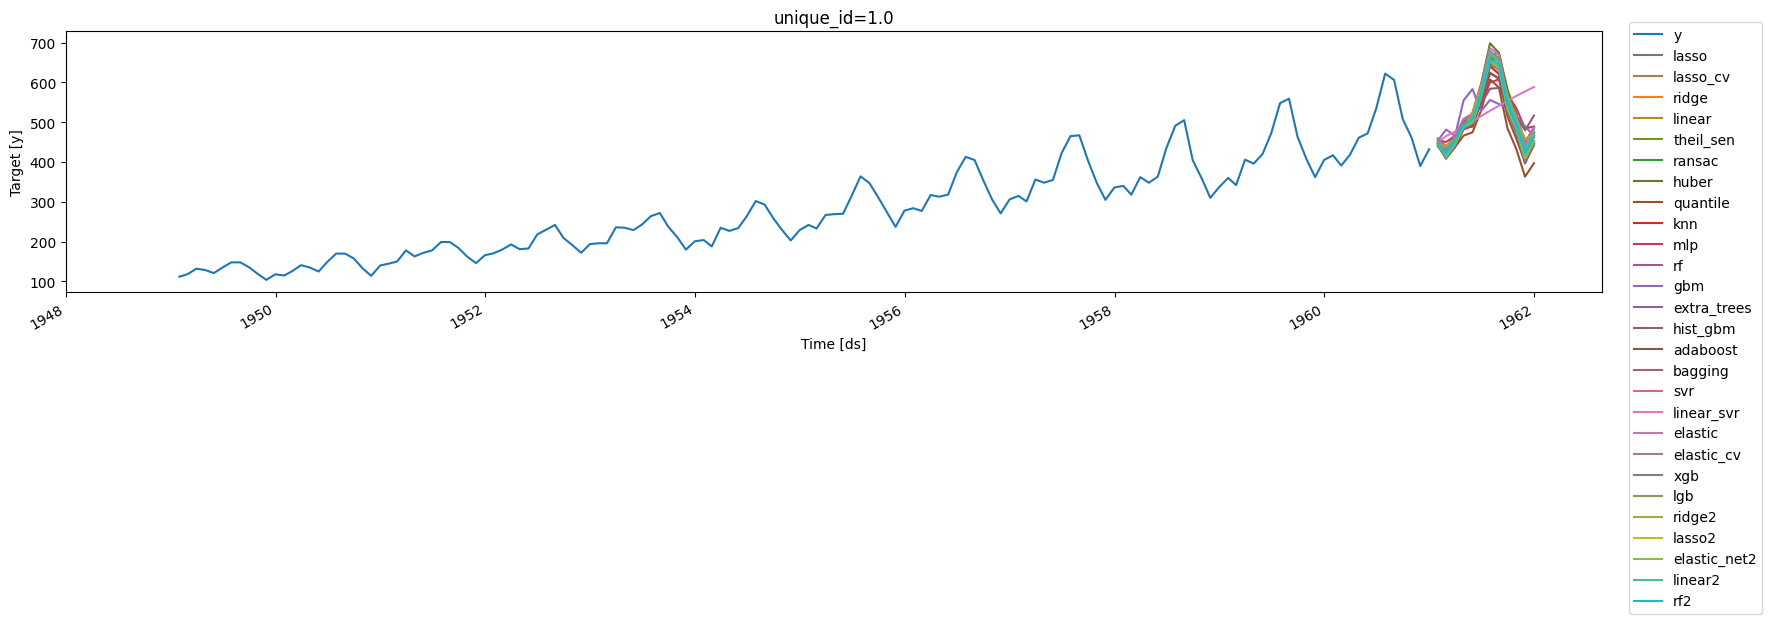

In [24]:
plot_series(df, auto_mlf.predict(h = 12))

In [25]:
df

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0
...,...,...,...
139,1.0,1960-08-31,606.0
140,1.0,1960-09-30,508.0
141,1.0,1960-10-31,461.0
142,1.0,1960-11-30,390.0


In [26]:
from functools import partial
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression, HuberRegressor, RANSACRegressor, TheilSenRegressor, QuantileRegressor
from utilsforecast.feature_engineering import pipeline, trend, fourier, time_features
from utilsforecast.plotting import plot_series

from statsforecast import StatsForecast
from statsforecast.models import SklearnModel
from statsforecast.utils import ConformalIntervals

In [27]:
train_features, valid_features = pipeline(
    df,
    features=[
        trend,        
        partial(fourier, season_length=12, k=12),  # 10 fourier terms
    ],
    freq="ME",
    h=12,
)
train_features.head()

,unique_id,ds,y,trend,sin1_12,sin2_12,sin3_12,sin4_12,sin5_12,sin6_12,...,cos3_12,cos4_12,cos5_12,cos6_12,cos7_12,cos8_12,cos9_12,cos10_12,cos11_12,cos12_12
0,1.0,1949-01-31,112.0,1.0,0.500000,8.660254e-01,1.000000e+00,8.660254e-01,0.500000,-8.742278e-08,...,-4.371139e-08,-0.5,-8.660254e-01,-1.0,-8.660254e-01,-0.5,1.192488e-08,0.5,8.660253e-01,1.0
1,1.0,1949-02-28,118.0,2.0,0.866025,8.660254e-01,-8.742278e-08,-8.660254e-01,-0.866025,1.748456e-07,...,-1.000000e+00,-0.5,4.999999e-01,1.0,5.000000e-01,-0.5,-1.000000e+00,-0.5,4.999996e-01,1.0
2,1.0,1949-03-31,132.0,3.0,1.000000,-8.742278e-08,-1.000000e+00,1.748456e-07,1.000000,-2.384976e-08,...,1.192488e-08,1.0,1.390709e-07,-1.0,-2.900667e-07,1.0,-3.577464e-08,-1.0,-5.920583e-07,1.0
3,1.0,1949-04-30,129.0,4.0,0.866025,-8.660254e-01,1.748456e-07,8.660253e-01,-0.866025,3.496911e-07,...,1.000000e+00,-0.5,-5.000002e-01,1.0,-5.000000e-01,-0.5,1.000000e+00,-0.5,-5.000007e-01,1.0
4,1.0,1949-05-31,121.0,5.0,0.500000,-8.660254e-01,1.000000e+00,-8.660253e-01,0.500000,-6.755325e-07,...,-3.377662e-07,-0.5,8.660253e-01,-1.0,8.660250e-01,-0.5,5.962440e-08,0.5,-8.660259e-01,1.0


In [28]:
import os
os.environ['NIXTLA_ID_AS_COL'] = '1'
sf = StatsForecast(
    models=[
        SklearnModel(Lasso(), alias="lasso_local"),
        SklearnModel(Ridge(), alias="ridge_local"),
        SklearnModel(ElasticNet(), alias="elastic_local"),
        SklearnModel(LinearRegression(), alias="linear_local"),
        SklearnModel(HuberRegressor(), alias="huber_local"),
        SklearnModel(RANSACRegressor(), alias="ransac_local"),
        # SklearnModel(TheilSenRegressor(), alias="theil_sen_local"),
        SklearnModel(QuantileRegressor(), alias="quantile_local"),
        
    ],
    freq="ME",
)
preds = sf.forecast(
    df=train_features,
    h=12,
    X_df=valid_features,
    prediction_intervals=ConformalIntervals(n_windows=4, h=12),
    level=[95],
)

In [29]:
preds

,unique_id,ds,lasso_local,lasso_local-lo-95,lasso_local-hi-95,ridge_local,ridge_local-lo-95,ridge_local-hi-95,elastic_local,elastic_local-lo-95,...,linear_local-hi-95,huber_local,huber_local-lo-95,huber_local-hi-95,ransac_local,ransac_local-lo-95,ransac_local-hi-95,quantile_local,quantile_local-lo-95,quantile_local-hi-95
0,1.0,1961-01-31,452.847168,433.866699,471.827637,449.418243,433.277466,465.558990,458.649048,435.164459,...,462.299225,440.982697,427.429291,454.536072,3.956175e+02,3.501714e+02,4.410636e+02,441.941162,432.921204,450.961151
1,1.0,1961-02-28,448.091644,410.727020,485.456268,442.733521,411.188263,474.278778,455.069580,413.668915,...,455.017609,432.162598,406.843353,457.481812,4.146606e+02,3.983003e+02,4.310210e+02,444.270599,419.173157,469.368011
2,1.0,1961-03-31,472.334351,450.898193,493.770538,477.675751,456.143280,499.208191,476.167755,455.258698,...,482.857666,470.147675,451.333069,488.962280,4.685231e+02,4.567707e+02,4.802754e+02,446.600006,406.879974,486.320007
3,1.0,1961-04-30,474.938934,448.966095,500.911743,474.632172,448.416687,500.847656,476.742065,451.671265,...,479.988495,467.634949,436.753357,498.516541,4.699013e+02,4.394460e+02,5.003565e+02,448.929413,404.855072,493.003754
4,1.0,1961-05-31,485.071350,459.236908,510.905792,479.367889,448.000397,510.735382,482.519775,454.304657,...,544.190491,472.087555,434.775116,509.399994,4.758018e+02,4.176072e+02,5.339964e+02,451.258820,397.249115,505.268524
5,1.0,1961-06-30,519.440308,460.006927,578.873657,518.945007,458.357849,579.532104,508.338043,439.730316,...,633.485718,508.518219,436.400818,580.635620,5.544600e+02,5.084246e+02,6.004954e+02,453.588226,339.961273,567.215210
6,1.0,1961-07-31,553.643311,443.688416,663.598206,558.355530,453.137085,663.573975,533.649475,406.290161,...,723.668518,535.843750,406.445557,665.241943,5.708370e+02,4.230080e+02,7.186660e+02,455.917633,260.219086,651.616211
7,1.0,1961-08-31,552.011047,453.076630,650.945496,558.126099,465.204468,651.047668,533.978088,418.999023,...,632.293030,533.118164,415.528839,650.707458,3.479187e+06,3.479084e+06,3.479290e+06,458.247070,276.054047,640.440063
8,1.0,1961-09-30,508.584198,462.229279,554.939148,509.813660,464.891144,554.736145,504.319061,454.732788,...,560.774353,501.924042,449.918457,553.929688,4.848126e+02,3.950006e+02,5.746246e+02,460.576477,378.264008,542.888916
9,1.0,1961-10-31,472.746735,446.257782,499.235687,474.245453,448.998749,499.492157,480.905884,461.218353,...,490.033936,467.150513,435.870972,498.430084,4.425063e+02,3.993568e+02,4.856557e+02,462.905884,431.398987,494.412781


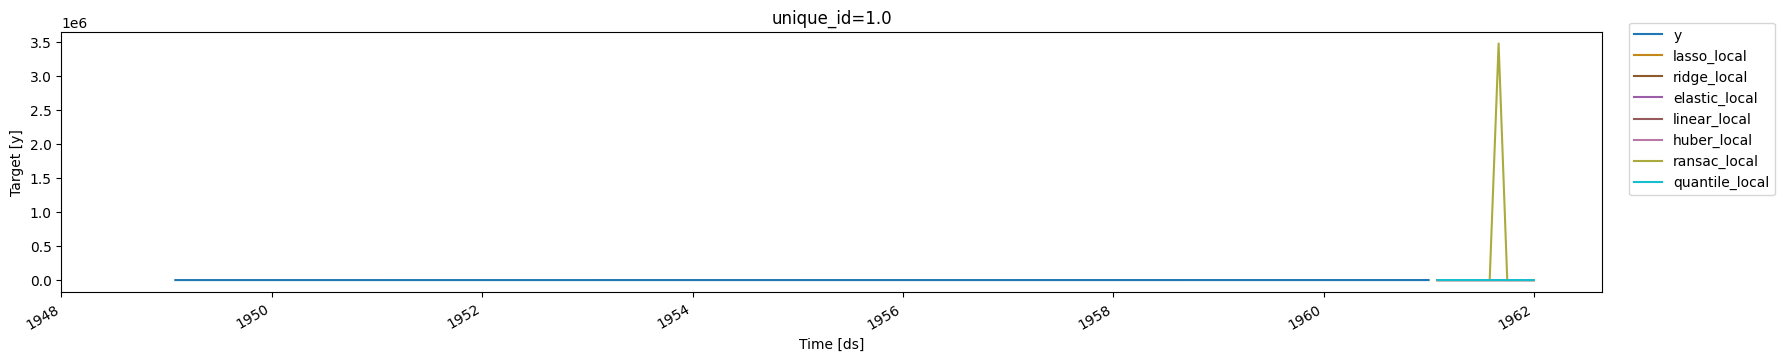

In [30]:
plot_series(df, preds)

In [31]:
auto_df =auto_mlf.predict(h = 12)

In [32]:
import pandas as pd
all = pd.merge(auto_df, preds, on=['unique_id','ds'])

In [33]:
all

,unique_id,ds,lasso,lasso_cv,ridge,linear,theil_sen,ransac,huber,quantile,...,linear_local-hi-95,huber_local,huber_local-lo-95,huber_local-hi-95,ransac_local,ransac_local-lo-95,ransac_local-hi-95,quantile_local,quantile_local-lo-95,quantile_local-hi-95
0,1.0,1961-01-31,458.820993,454.028469,452.462133,444.240848,449.457420,444.582979,451.966582,440.751412,...,462.299225,440.982697,427.429291,454.536072,3.956175e+02,3.501714e+02,4.410636e+02,441.941162,432.921204,450.961151
1,1.0,1961-02-28,439.286604,437.916110,437.564055,419.136089,428.789681,419.475361,427.649016,408.172067,...,455.017609,432.162598,406.843353,457.481812,4.146606e+02,3.983003e+02,4.310210e+02,444.270599,419.173157,469.368011
2,1.0,1961-03-31,461.870366,461.311933,455.301747,447.158244,451.113703,444.702880,455.663343,437.387055,...,482.857666,470.147675,451.333069,488.962280,4.685231e+02,4.567707e+02,4.802754e+02,446.600006,406.879974,486.320007
3,1.0,1961-04-30,500.143598,500.684905,487.684676,488.769904,493.309595,487.529075,495.819069,466.277265,...,479.988495,467.634949,436.753357,498.516541,4.699013e+02,4.394460e+02,5.003565e+02,448.929413,404.855072,493.003754
4,1.0,1961-05-31,513.524613,520.461701,525.216509,500.027668,512.075244,502.971516,519.038726,474.395316,...,544.190491,472.087555,434.775116,509.399994,4.758018e+02,4.176072e+02,5.339964e+02,451.258820,397.249115,505.268524
5,1.0,1961-06-30,569.588937,581.792550,595.722305,561.736704,574.597956,566.441381,595.727454,529.332559,...,633.485718,508.518219,436.400818,580.635620,5.544600e+02,5.084246e+02,6.004954e+02,453.588226,339.961273,567.215210
6,1.0,1961-07-31,650.259334,662.871482,675.585391,645.980011,668.321676,659.277657,698.169470,607.201195,...,723.668518,535.843750,406.445557,665.241943,5.708370e+02,4.230080e+02,7.186660e+02,455.917633,260.219086,651.616211
7,1.0,1961-08-31,644.766091,656.200290,660.062763,631.347106,674.041603,655.142501,674.070065,587.208793,...,632.293030,533.118164,415.528839,650.707458,3.479187e+06,3.479084e+06,3.479290e+06,458.247070,276.054047,640.440063
8,1.0,1961-09-30,560.465645,570.609934,577.550170,537.317428,581.819194,557.114995,577.755835,484.422508,...,560.774353,501.924042,449.918457,553.929688,4.848126e+02,3.950006e+02,5.746246e+02,460.576477,378.264008,542.888916
9,1.0,1961-10-31,511.808044,512.811716,502.028711,491.921173,519.995605,495.990979,519.592982,431.988521,...,490.033936,467.150513,435.870972,498.430084,4.425063e+02,3.993568e+02,4.856557e+02,462.905884,431.398987,494.412781


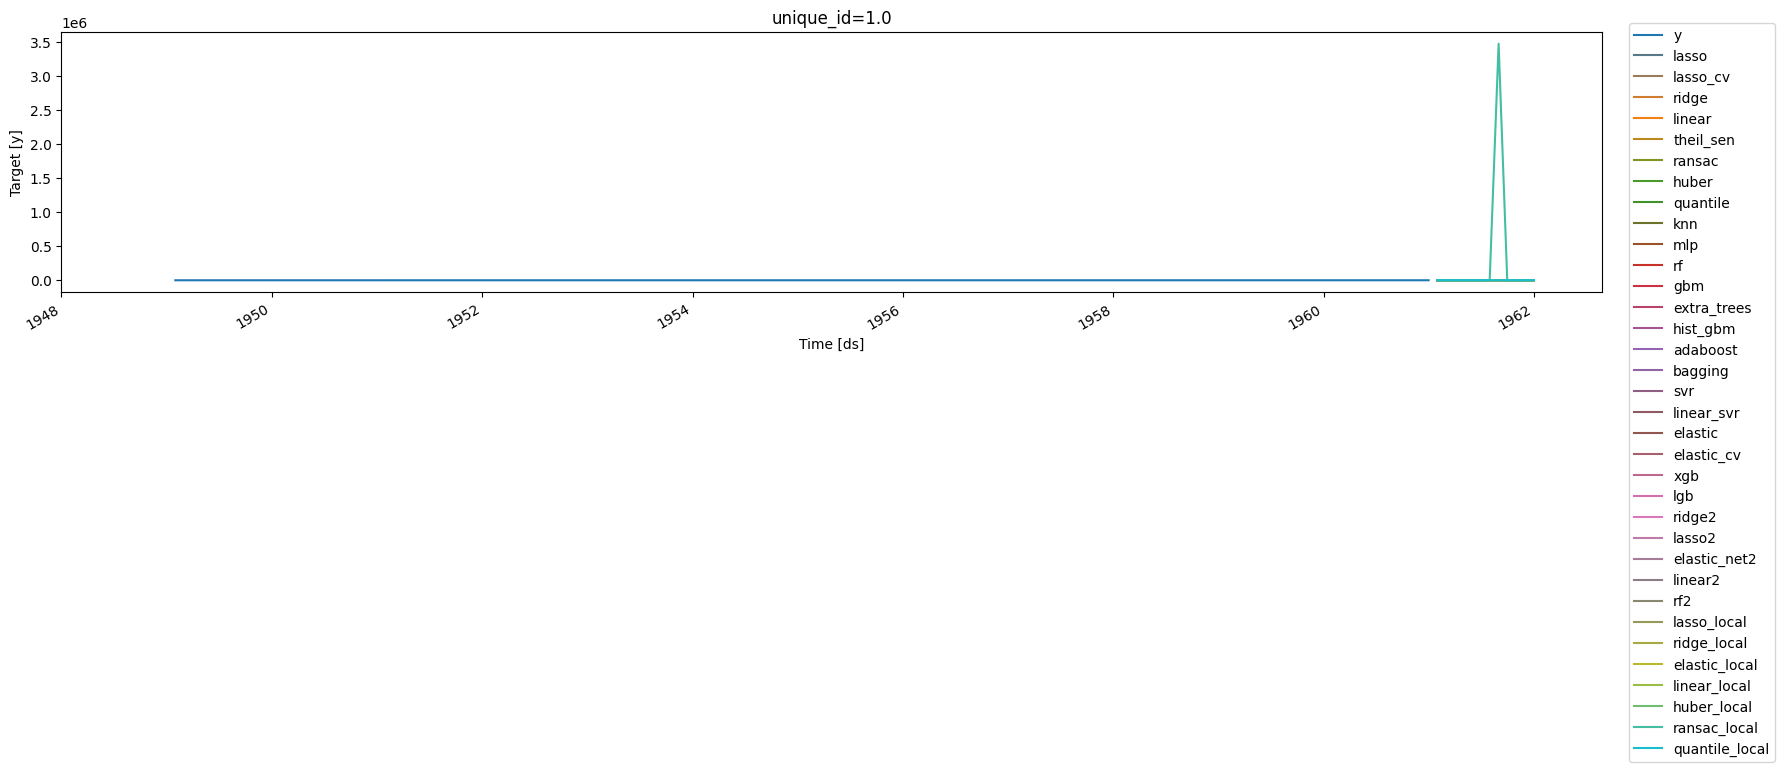

In [34]:
plot_series(df, all)

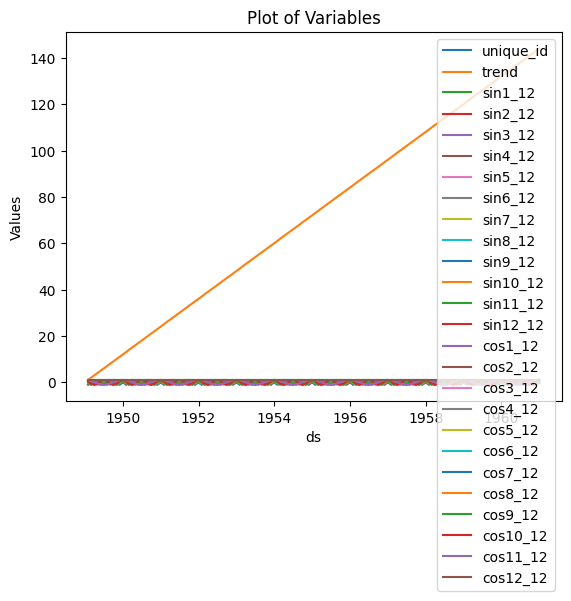

In [35]:
import matplotlib.pyplot as plt

# Set the x-axis as 'ds'
x = train_features['ds']

# Set the y-axis as all other variables
y_variables = [var for var in train_features.columns if var != 'ds' and var != 'y']

# Plot each variable
for var in y_variables:
    plt.plot(x, train_features[var], label=var)

# Set the x-axis label
plt.xlabel('ds')

# Set the y-axis label
plt.ylabel('Values')

# Set the title of the plot
plt.title('Plot of Variables')


# Add a legend
plt.legend()

# Show the plot
plt.show()